In [1]:
# Install the Kaggle API client.
!pip install -q kaggle

In [2]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"superingram","key":"8cb8b87552cf4c9a4843b7f0ebeea6d6"}'}

In [3]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Apr  7 17:42 kaggle.json


In [4]:
# This code will allow folders to be imported from Kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=4da4268cefe67d60e65607684dc4b6ddcdde7f2c7913da601288ea77b1a46349
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [5]:
# The Kaggle API client expects this file to be in ~/.kaggle,

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Copy the Kaggle data set locally.
!kaggle competitions download -c plant-pathology-2021-fgvc8

100% 14.9G/14.9G [03:51<00:00, 90.2MB/s]
100% 14.9G/14.9G [03:51<00:00, 69.0MB/s]


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
from PIL import Image
import seaborn as sns
from IPython.display import Image, display
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout

In [10]:
# unzipping the zipped file and deleting the zipped file
!unzip \*.zip


Streaming output truncated to the last 5000 lines.
  inflating: train_images/e00c97b2de4749ce.jpg  
  inflating: train_images/e00df890cfe62736.jpg  
  inflating: train_images/e00ed0bf43a87f25.jpg  
  inflating: train_images/e00f759d65d52887.jpg  
  inflating: train_images/e00f934d9e50ad5b.jpg  
  inflating: train_images/e00fce341cb63da5.jpg  
  inflating: train_images/e010c7c35ecf3d1c.jpg  
  inflating: train_images/e01112939f783fec.jpg  
  inflating: train_images/e01592da4d71b8be.jpg  
  inflating: train_images/e0189acaf8cf80fd.jpg  
  inflating: train_images/e0189e4999bdd0fa.jpg  
  inflating: train_images/e01ae16d4a759cb5.jpg  
  inflating: train_images/e01dc39ccb2b4ccb.jpg  
  inflating: train_images/e01e42d90c66f3f3.jpg  
  inflating: train_images/e01e870bec65f40f.jpg  
  inflating: train_images/e01f17e0187fb80f.jpg  
  inflating: train_images/e01f503cb752e6c5.jpg  
  inflating: train_images/e024b69a784e9fc3.jpg  
  inflating: train_images/e026b4c23c9fcfc4.jpg  
  inflating: train

In [52]:
# The training images will be formatted and resized.  
# The training set with images will have to be reduced as the RAM will not read in all 18000 images.
# A new test set will be created from some of the remaining training images.

root = '/content/train_images'
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [64, 64])
    img = tf.cast(img, tf.uint8)
    return img.numpy()

df = pd.read_csv('/content/train.csv')[:10000]

df['image'] = [os.path.join(root, x) for x in df['image']]

trainset = []
for x in (df['image']):
    trainset.append(load_image(x))

In [20]:
df.head()

,image,labels
0,/content/train_images/800113bb65efe69e.jpg,healthy
1,/content/train_images/8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,/content/train_images/80070f7fb5e2ccaa.jpg,scab
3,/content/train_images/80077517781fb94f.jpg,scab
4,/content/train_images/800cbf0ff87721f8.jpg,complex


In [53]:
df.shape

(10000, 2)

In [54]:
df.describe()

,image,labels
count,10000,10000
unique,10000,12
top,/content/train_images/a19fbe7c4b45b0a0.jpg,scab
freq,1,2644


In [23]:
df['labels'].unique()

array(['healthy', 'scab frog_eye_leaf_spot complex', 'scab', 'complex',
       'rust', 'frog_eye_leaf_spot', 'powdery_mildew',
       'scab frog_eye_leaf_spot', 'frog_eye_leaf_spot complex',
       'rust frog_eye_leaf_spot', 'powdery_mildew complex',
       'rust complex'], dtype=object)

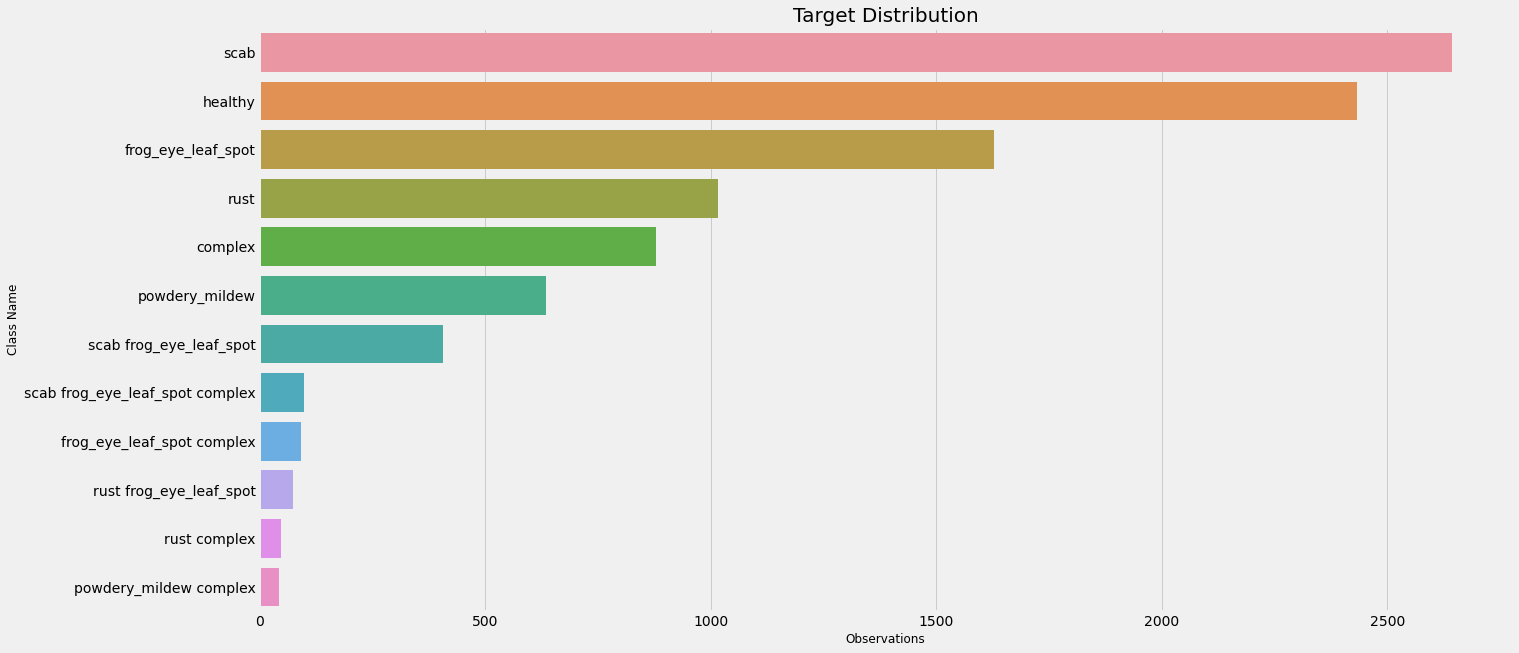

In [55]:
targets=df.labels.value_counts()
fig = plt.figure(figsize=(20,10))
sns.barplot(y=targets.sort_values(ascending=False).index, x=targets.sort_values(ascending=False).values)
plt.title('Target Distribution', size = 20)
plt.xlabel("Observations", size=12)
plt.ylabel("Class Name", size=12)
plt.show()
# The labels are not evenly distributed and consist of spaces which will be a problem.  
# We will have to remove these labels before entering into a neural network.

In [28]:
# Reading in test images to numpy array since there is only three.

folders = glob.glob('/content/test_images*')
image_names = []
for folder in folders:
    for f in glob.glob(folder+'/*.jpg'):
        image_names.append(f)

test_images = []        
for image in image_names:
    test_images.append(cv2.imread(image))
    

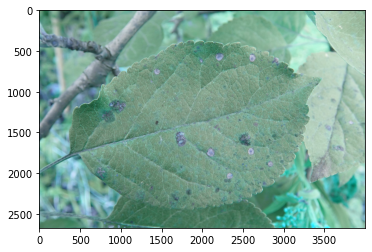

In [29]:
# Displaying the first test image.
plt.imshow(test_images[0])

In [30]:
# The first image has a length of 2672 and a width of 4000 with a depth of three channels indicating a color image.
test_images[0].shape

(2672, 4000, 3)

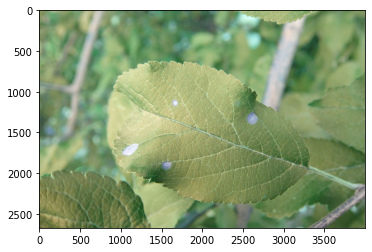

In [31]:
# Displaying the second test image.
plt.imshow(test_images[1])

In [32]:
# The second image has the same length, width and depth as the second.
test_images[1].shape

(2672, 4000, 3)

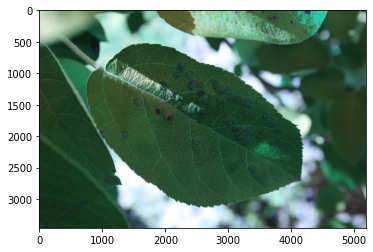

In [33]:
# Displaying the third test image.
plt.imshow(test_images[2])

In [34]:
# The third image has a length of 3456 and a width of 5184 !
test_images[2].shape

(3456, 5184, 3)

In [35]:
# Creating a class to compare labels against.
# We are only using 6.  

plt.style.use('fivethirtyeight')

class BDI:
    
    root = '/content/train_images'
    classes = [
        'complex', 
        'frog_eye_leaf_spot', 
        'powdery_mildew', 
        'rust', 
        'scab',
        'healthy']
    strategy = tf.distribute.get_strategy()
    batch_size = 16


In [56]:
# The MultiLabelBinarizer is used to remove whitespace in our labels.
df.set_index('image', inplace=True)

init_labels = df['labels'].values.copy()

df['labels'] = [x.split(' ') for x in df['labels']]
labels = MultiLabelBinarizer(classes=BDI.classes).fit_transform(df['labels'].values)

train = pd.DataFrame(columns=BDI.classes, data=labels, index=df.index)

train.head()

,complex,frog_eye_leaf_spot,powdery_mildew,rust,scab,healthy
image,,,,,,
/content/train_images/800113bb65efe69e.jpg,0,0,0,0,0,1
/content/train_images/8002cb321f8bfcdf.jpg,1,1,0,0,1,0
/content/train_images/80070f7fb5e2ccaa.jpg,0,0,0,0,1,0
/content/train_images/80077517781fb94f.jpg,0,0,0,0,1,0
/content/train_images/800cbf0ff87721f8.jpg,1,0,0,0,0,0


In [57]:
# The dataframe still has 10000 rows and now, 6 columns.
train.describe

<bound method NDFrame.describe of                                             complex  ...  healthy
image                                                ...         
/content/train_images/800113bb65efe69e.jpg        0  ...        1
/content/train_images/8002cb321f8bfcdf.jpg        1  ...        0
/content/train_images/80070f7fb5e2ccaa.jpg        0  ...        0
/content/train_images/80077517781fb94f.jpg        0  ...        0
/content/train_images/800cbf0ff87721f8.jpg        1  ...        0
...                                             ...  ...      ...
/content/train_images/c52d4456a52a7b73.jpg        0  ...        0
/content/train_images/c530324bafc7729a.jpg        1  ...        0
/content/train_images/c5319a4f47e2f0c6.jpg        0  ...        0
/content/train_images/c53252d80af82ff5.jpg        0  ...        0
/content/train_images/c5339e87235c6ac5.jpg        0  ...        0

[10000 rows x 6 columns]>

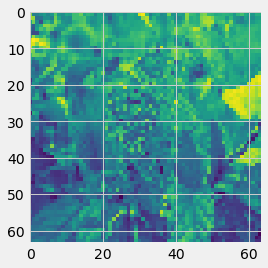

In [59]:
# Taking a look at the training images
plt.imshow(trainset[400].reshape(64, 64))

In [69]:
# Creating test set to test on with CNN

tester = pd.read_csv('/content/train.csv')[10001:12500]

tester['image'] = [os.path.join(root, x) for x in tester['image']]

test_set = []
for x in (tester['image']):
    test_set.append(load_image(x))

In [70]:
# The MultiLabelBinarizer is used again remove whitespace in our labels for the test set.
tester.set_index('image', inplace=True)

test_init_labels = tester['labels'].values.copy()

tester['labels'] = [x.split(' ') for x in tester['labels']]
test_labels = MultiLabelBinarizer(classes=BDI.classes).fit_transform(tester['labels'].values)

test = pd.DataFrame(columns=BDI.classes, data=test_labels, index=tester.index)

test.head()

,complex,frog_eye_leaf_spot,powdery_mildew,rust,scab,healthy
image,,,,,,
/content/train_images/c536ddcc38c126d5.jpg,0,0,0,0,0,1
/content/train_images/c537c2cd2d92b549.jpg,0,0,0,0,0,1
/content/train_images/c538c6d3943fd294.jpg,0,0,0,0,1,0
/content/train_images/c53b70395fb1b130.jpg,0,0,0,0,1,0
/content/train_images/c53b9e87215c6ac5.jpg,0,0,0,1,0,0


In [71]:
trainset = np.array(trainset)/255.0
test_set = np.array(test_set)/255.0

In [ ]:
# Initializes a sequential CNN model
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(10, kernel_size=3, activation='relu', 
               input_shape=(64, 64, 1), padding='same', strides=2))

# Add a pooling layer

model.add(MaxPool2D(2))

# Add a dropout layer
model.add(Dropout(0.2))

# Add another convolutional layer
model.add(Conv2D(5, kernel_size=2, activation='relu'))

# Flatten the output of the convolutional layer
model.add(Flatten())

# Output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
           loss='categorical_crossentropy', 
           metrics=['accuracy'])


In [ ]:
# Reshape the data to two-dimensional array
trainset = trainset.reshape(64,64)

# Fit the model
model.fit(trainset, labels, validation_split=0.2, epochs=3, batch_size=10)

In [ ]:
# Reshape test data
test_set = test_set.reshape(64,64)

# Evaluate the model
model.evaluate(test_set, test_labels, batch_size=10)

In [ ]:
# Extract the history from the training object
history = training.history

# Plot the training loss 
plt.plot(history['loss'])
# Plot the validation loss
plt.plot(history['val_loss'])

# Show the figure
plt.show()

In [ ]:
# Load the weights from file
model.load_weights('weights.hdf5')

# Predict from the test data
model.predict(test_set)